<a href="https://colab.research.google.com/github/MichSteczko/Kaggle_competitions-/blob/main/NCAAW_tournament.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
from google.colab import drive
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import log_loss
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')

Mounted at /content/drive


# Data preprocessing

## Loading the data from google drive



In [144]:
path = "/content/drive/MyDrive/NCAAW/stage2/"
ss = pd.read_csv(path+'WSampleSubmissionStage2.csv') # sample submission file
sd = pd.read_csv(path+'WRegularSeasonCompactResults.csv') # season data
td = pd.read_csv(path+'WNCAATourneyCompactResults.csv') # tourney data
ts = pd.read_csv(path+'WNCAATourneySeeds.csv') # tourney seeds

In [145]:
print(sd.shape)
sd.head()

(115739, 8)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1998,18,3104,91,3202,41,H,0
1,1998,18,3163,87,3221,76,H,0
2,1998,18,3222,66,3261,59,H,0
3,1998,18,3307,69,3365,62,H,0
4,1998,18,3349,115,3411,35,H,0


In [146]:
print(td.shape)
td.head()

(1386, 8)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1998,137,3104,94,3422,46,H,0
1,1998,137,3112,75,3365,63,H,0
2,1998,137,3163,93,3193,52,H,0
3,1998,137,3198,59,3266,45,H,0
4,1998,137,3203,74,3208,72,A,0


## Adding a random position to each team

In [3]:
# shuffle the teams table position
def shuffle_data(df):
  for i in df.index:
      if random.choices([0,1]) == [1]:
          df.at[i, 'Team1'] = df.at[i, 'WTeamID']
          df.at[i, 'Team2'] = df.at[i, 'LTeamID']
          df.at[i, 'target'] = 1
      else:
          df.at[i, 'Team1'] = df.at[i, 'LTeamID']
          df.at[i, 'Team2'] = df.at[i, 'WTeamID']
          df.at[i, 'target'] = 0
  return df 

## Function that adds seeds to each team


In [4]:
def add_seed(df):
  ts['TeamID'] = ts['TeamID'].astype(np.int)
  df = df.merge(ts, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'T1Seed'})
  df = df.merge(ts, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'Seed': 'T2Seed'})
  df['T1Seed'] = df['T1Seed'].str.replace(r'[^0-9]', '').astype('float')
  df['T2Seed'] = df['T2Seed'].str.replace(r'[^0-9]', '').astype('float')
  return df

# Elo Engineerging

## Function that sets up starting ELO 

In [6]:
def starting_elo(df):
  df['elo_t1'] = 0.0
  df['elo_t2'] = 0.0
  teams = pd.concat([df['Team1'], df['Team2']])
  for team in teams.unique():
    index_t1 = df.where(team==df['Team1']).first_valid_index()
    index_t2 = df.where(team==df['Team2']).first_valid_index()
    df.at[index_t1, 'elo_t1'] = 1500.0
    df.at[index_t2, 'elo_t2'] = 1500.0
  df = df.sort_values(by=['DayNum'])
  return df  

## Function that calculates the ELO value
$$ Elo_{i + 1} = k \cdot (S_{team} - E_{team}) + Elo_i$$
where $$E_{team} = \frac{1}{10^{\frac{opp\_elo - team\_elo}{400}} + 1} $$
, $$k = 20 \cdot \frac{(Mov\_multiplier + 3)^{0.8}}{7.5 + 0.006 \cdot (elo_{winner} - elo_{loser})} $$
, $$MovMultiplier = \ln{(abs(Point\_diffrence) + 1)} \cdot \frac{2.2}{(ELO\_winner - ELO\_loser) \cdot0.001+2.2} $$
,
$$S\_team = 0, \ if \ team \ lost $$

$$S\_team = 1, \ if \ team \ won $$

In [7]:
def calculate_elo(elo_winner, elo_loser, w_points, l_points):
  E1 = 1/(10**((elo_loser - elo_winner)/400) + 1)
  E2 = 1/(10**((elo_winner - elo_loser)/400) + 1)
  S1 = 1
  S2 = 0
  mov_multi = np.log(abs(w_points - l_points) + 1) * 2.2/((elo_winner - elo_loser) * 0.001 + 2.2)
  K = 20 * (mov_multi + 3)**0.8/(7.5 + 0.006*(elo_winner - elo_loser))
  elo_winner = elo_winner + K*(S1 - E1)
  elo_loser = elo_loser + K*(S2 - E2)
  return elo_winner, elo_loser

## Function that changes ELO when it's moving from season to season

In [8]:
def change_elo(elo):
  return (elo*0.75) + (0.25 * 1505)

## Function responsible for changing elo season to season.

In [9]:
def elo_swap(pol, top):  
  pol = pol.reset_index()
  pol['elo_t1'] = 0.0
  pol['elo_t2'] = 0.0
  teamss = pd.concat([pol['Team1'], pol['Team2']]).unique()
  teams = pd.concat([top['Team1'], top['Team2']]).unique()
  elo = 0.0
  for team in teamss:
    if team in teams:
      index_t1 = pol.where((team==pol['Team1']) | (team==pol['Team2'])).first_valid_index()
      index_t2 = top.where((team==top['Team1']) | (team==top['Team2'])).last_valid_index()
      
      if top.at[index_t2, 'Team1'] == team: 
        elo = change_elo(top.at[index_t2, 'elo_t1'])
      if top.at[index_t2, 'Team2'] == team:
        elo = change_elo(top.at[index_t2, 'elo_t2'])
    
      if pol.at[index_t1, 'Team1'] == team:
        pol.at[index_t1, 'elo_t1'] = elo
      
      if pol.at[index_t1, 'Team2'] == team:
        pol.at[index_t1, 'elo_t2'] = elo  
    
    if team not in teams:
      index_t1 = pol.where((team==pol['Team1']) | (team==pol['Team2'])).first_valid_index()
      if pol.at[index_t1, 'Team1'] == team:
        pol.at[index_t1, 'elo_t1'] = 1500.0
      
      if pol.at[index_t1, 'Team2'] == team:
        pol.at[index_t1, 'elo_t2'] = 1500.0
  
  return pol

## Function that calculates ELO for each team at each season

In [10]:
def elo_stats(df):
  sklejka = []
  seasons = list(df['Season'].unique())
  seasons = seasons[seasons.index(1998):]
  for season in seasons:
    if season == 1998:
      top = df.loc[df['Season'] == season]
      top = starting_elo(top)
      top = top.reset_index()
    else:
      top = pol  
    for i, row in top.iterrows():
      if top.at[i,'Team1'] == top.at[i,'WTeamID']:
        elo_winner = top.at[i, 'elo_t1']
        elo_loser = top.at[i, 'elo_t2']
        t2 = top.at[i, 'Team2']
        t1 = top.at[i, 'Team1']
        w_score= top.at[i, 'WTeamID'] # check this out
        l_score = top.at[i, 'LTeamID']
        e1 = top[(top['Team1'] == t1) | (top['Team2'] == t1)].index.to_list()
        e2 = top[(top['Team1'] == t2) | (top['Team2'] == t2)].index.to_list()
        
        try:
          next_index = e1[e1.index(i) + 1]
        except:
          next_index = e1[e1.index(i)]
        try: 
          next_index2 = e2[e2.index(i) + 1]
        except:
          next_index2 = e2[e2.index(i)]  
      
      if top.at[i,'Team2'] == top.at[i,'WTeamID']:
        elo_winner = top.at[i, 'elo_t2']
        elo_loser = top.at[i, 'elo_t1']
        w_score= top.at[i, 'WTeamID'] # check this out
        l_score = top.at[i, 'LTeamID']
        t1 = top.at[i, 'Team2']
        t2 = top.at[i, 'Team1']
        e1 = top[(top['Team1'] == t1) | (top['Team2'] == t1)].index.to_list()
        e2 = top[(top['Team1'] == t2) | (top['Team2'] == t2)].index.to_list()
        try:
          next_index = e1[e1.index(i) + 1]
        except:
          next_index = e1[e1.index(i)]
        try:
          next_index2 = e2[e2.index(i) + 1]
        except:
          next_index2 = e2[e2.index(i)]
   
      
        
        
      ew, el = calculate_elo(elo_winner, elo_loser, w_score, l_score)   
    
              
      if top.at[next_index2, 'Team1'] == t2:
        top.at[next_index2, 'elo_t1'] = el
      
      if top.at[next_index2, 'Team2'] == t2:
        top.at[next_index2, 'elo_t2'] = el  
      
      if top.at[next_index, 'Team1'] == t1:
        top.at[next_index, 'elo_t1'] = ew
      
      if top.at[next_index, 'Team2'] == t1:
        top.at[next_index, 'elo_t2'] = ew

    if season < 2021:
      pol = df.loc[df['Season']==seasons[seasons.index(season)+1]]
      pol = elo_swap(pol, top)
    sklejka.append(top)

  return pd.concat(sklejka)

In [14]:
datka = shuffle_data(sd)

In [15]:
kappa = elo_stats(datka)


In [ ]:
kappa.to_csv(path+'boosted_elo.csv', index=False)

In [ ]:
kappa = pd.read_csv(path+'boosted_elo.csv')

## Function that creates new dataframe with final ELO for each team at each season

In [18]:
def season_final_elo(df):
  seasons = list(df['Season'].unique())
  seasons = seasons[seasons.index(1998):]
  frames = []
  df = df.reset_index()
  for season in seasons: 
    df.loc[df['Season'] == season]
    teams = pd.concat([df['Team1'], df['Team2']]).unique()
    elo_frame = pd.DataFrame(teams, columns=['TeamID'])
    elo_frame['ELO'] = 0.0
    elo_frame['Season'] = season
    #elo_frame['Score'] = 0
    for team in teams:
      elo_index = df.where((team==df['Team1']) | (team==df['Team2'])).last_valid_index()
      team_index = elo_frame.where(team==elo_frame['TeamID']).first_valid_index()
      if df.at[elo_index, 'Team1'] == team:
        elo_frame.at[team_index, 'ELO'] = df.at[elo_index, 'elo_t1'] 
        #elo_frame.at[team_index, 'ELO'] = df.at[elo_index, 'Score_over_time_t1'] 
        
      if df.at[elo_index, 'Team2'] == team:
        elo_frame.at[team_index, 'ELO'] = df.at[elo_index, 'elo_t2'] 
        #elo_frame.at[team_index, 'ELO'] = df.at[elo_index, 'Score_over_time_t2']
    frames.append(elo_frame)  
  return pd.concat(frames)

In [19]:
team_elo_at_each_season = season_final_elo(kappa)

In [20]:
team_elo_at_each_season.to_csv(path+'boosted_elos_season.csv', index=False)

In [34]:
team_elo_at_each_season.head()

,TeamID,ELO,Season
0,3202.0,1463.945119,1998
1,3163.0,1788.241068,1998
2,3222.0,1559.593260,1998
3,3307.0,1544.322902,1998
4,3349.0,1637.761180,1998


In [ ]:
team_elo_at_each_season = pd.read_csv(path+'boosted_elos_season.csv')

# Win ratio 

In [21]:
def win_ratio(df):
  frames = []
  df = shuffle_data(df)
  df['T1_Score'] = np.select([df['Team1'] == df['WTeamID']],
                             [df['WScore']], 
                             df['LScore']
                             )
  df['T2_Score'] = np.select([df['Team2'] == df['WTeamID']],
                             [df['WScore']], 
                             df['LScore']
                            )               
  df['T1_win'] = np.select([df['Team1'] == df['WTeamID']], [1], 0)
  df['T2_win'] = np.select([df['Team2'] == df['WTeamID']], [1], 0)
  for season in df.Season.unique():
    ratio_frame = df.loc[df.Season == season]
    points_t1 = ratio_frame.groupby('Team1')['T1_Score'].sum().rename('Score').reset_index()
    points_t1.columns = ['TeamID', 'Score']
    points_t2 = ratio_frame.groupby('Team2')['T2_Score'].sum().rename('Score').reset_index()
    points_t2.columns = ['TeamID', 'Score']
    full_points = pd.concat([points_t1, points_t2])
    full_points = full_points.groupby('TeamID')['Score'].sum().reset_index()
    full_points.columns = ['PTeamID', 'Score']
    wins_t1 = ratio_frame.groupby('Team1')['T1_win'].sum().rename('Wins').reset_index()
    wins_t1.columns = ['TeamID', 'Wins']
    wins_t2 = ratio_frame.groupby('Team2')['T2_win'].sum().rename('Wins').reset_index()
    wins_t2.columns = ['TeamID', 'Wins']
    full_wins = pd.concat([wins_t1, wins_t2])
    full_wins = full_wins.groupby('TeamID')['Wins'].sum().reset_index()
    full_wins.columns = ['WTeamID', 'Wins']
    teams = pd.concat([ratio_frame.Team1, ratio_frame.Team2]).rename('TeamID').reset_index()
    teams = teams.groupby('TeamID').size().reset_index()
    teams.columns = ['TeamID', 'Games']
    teams = teams.merge(full_points, how='left', left_on=['TeamID'], right_on=['PTeamID']).drop('PTeamID', axis = 1) 
    teams = teams.merge(full_wins, how='left', left_on=['TeamID'], right_on=['WTeamID']).drop('WTeamID', axis = 1)
    teams['Season'] = season
    frames.append(teams)
  return pd.concat(frames).reset_index(drop=True)

In [23]:
win_rate_frame = win_ratio(sd)
win_rate_frame['TeamID'] = win_rate_frame['TeamID'].astype(np.int)


In [24]:
win_rate_frame['win_rate'] = [wins/games if wins > 0 else 0 for wins, games in zip(win_rate_frame['Wins'], win_rate_frame['Games'])]

In [25]:
win_rate_frame

,TeamID,Games,Score,Wins,Season,win_rate
0,3102,24,1375,4,1998,0.166667
1,3103,29,2008,11,1998,0.379310
2,3104,30,2297,21,1998,0.700000
3,3106,21,1286,6,1998,0.285714
4,3108,23,1560,12,1998,0.521739
...,...,...,...,...,...,...
8044,3467,15,970,5,2021,0.333333
8045,3468,22,1381,5,2021,0.227273
8046,3469,2,97,0,2021,0.000000
8047,3470,21,1230,5,2021,0.238095


# Ploting the results

## Ploting win ratio


In [ ]:
def plot_win_ratio(df):
  fig, axes = plt.subplots(6, 4, figsize=(300, 100), sharey=True)
  fig.suptitle('Win Rate')
  col = 0
  row = 0
  for season in df.Season.unique():
    if col == 4:
      row += 1
      col = 0
    plot_frame = df.loc[df.Season == season]
    plot = sns.barplot(ax = axes[row, col], x = plot_frame.TeamID, y = plot_frame.win_rate)
    plot.set_xticklabels(labels = plot_frame.TeamID, rotation=90)
    axes[row, col].set_title(season)
    col += 1

In [ ]:
plot_win_ratio(win_rate_frame)

## Ploting ELO rating

In [73]:
def plot_elo(df, teams: list):
  columns = ['Season', 'DayNum','Team1', 'Team2', 'elo_t1', 'elo_t2']
  colors = ['purple', 'green', 'blue']
  i = 0
  
  for team in teams:  
    plot_frame = df.loc[(df['Team1'] == team) | (df['Team2'] == team)]
    plot_frame = plot_frame[columns]
    conds = [plot_frame['Team1']== team]
    choices = [plot_frame['elo_t1']]
    plot_frame['ELO'] = np.select(conds, choices, plot_frame['elo_t2'])
    plot_frame = plot_frame.reset_index()
    dates = pd.to_datetime(plot_frame.Season.astype('str'), format='%Y') + \
     pd.to_timedelta(plot_frame.DayNum.div(7).astype('str') + 'day') # creating datetime object to see how ELO rating has changed
    plot_frame.index = dates # setting up index as datetime object
    fig, ax = plt.subplots(figsize=(30, 15))
    ax.plot(plot_frame.index.date,
            plot_frame['ELO'],
            color=colors[i],
          )
    ax.legend([str(team)])
    i += 1
    ax.set(xlabel="Year",
            ylabel="ELO Score",
            title="ELO rating over time")
  
  plt.show()

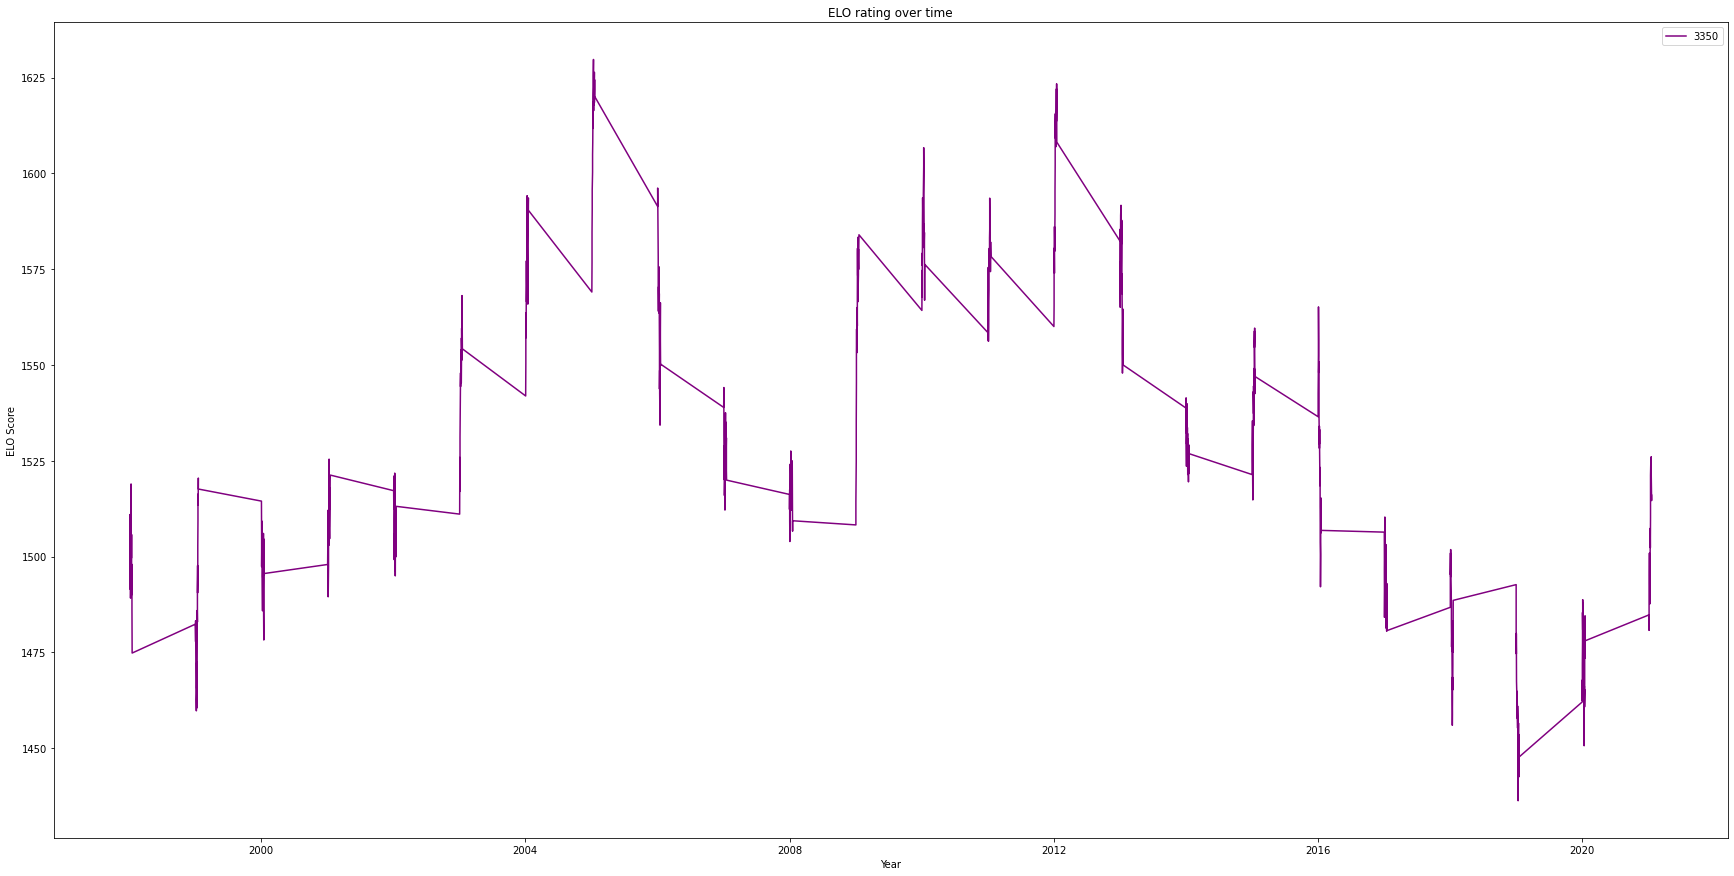

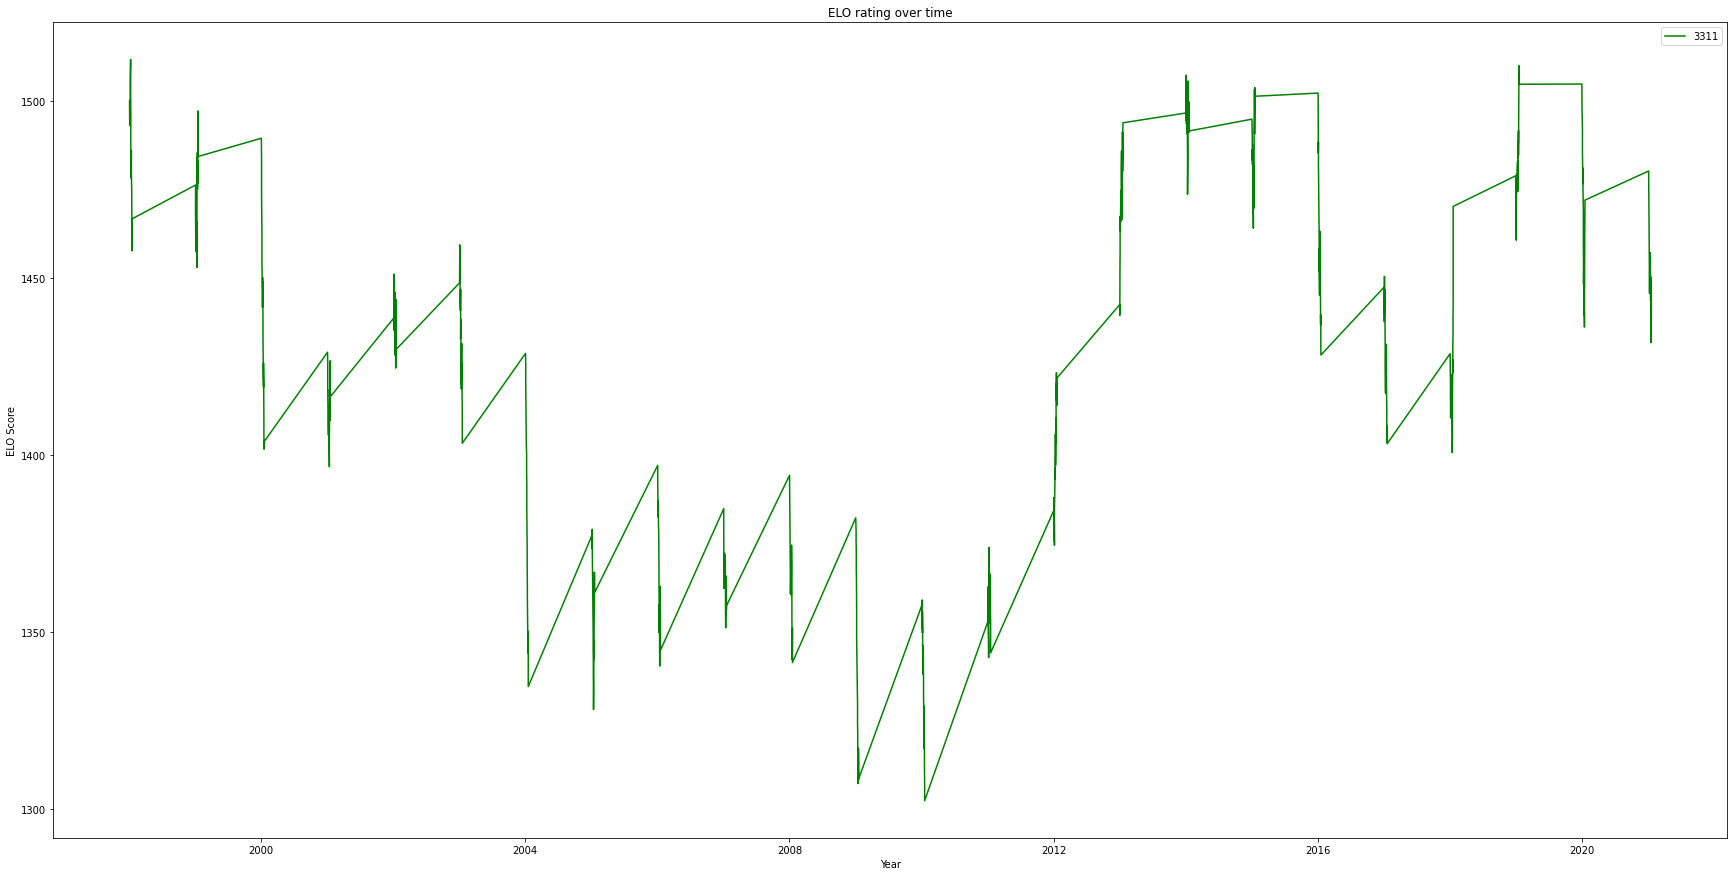

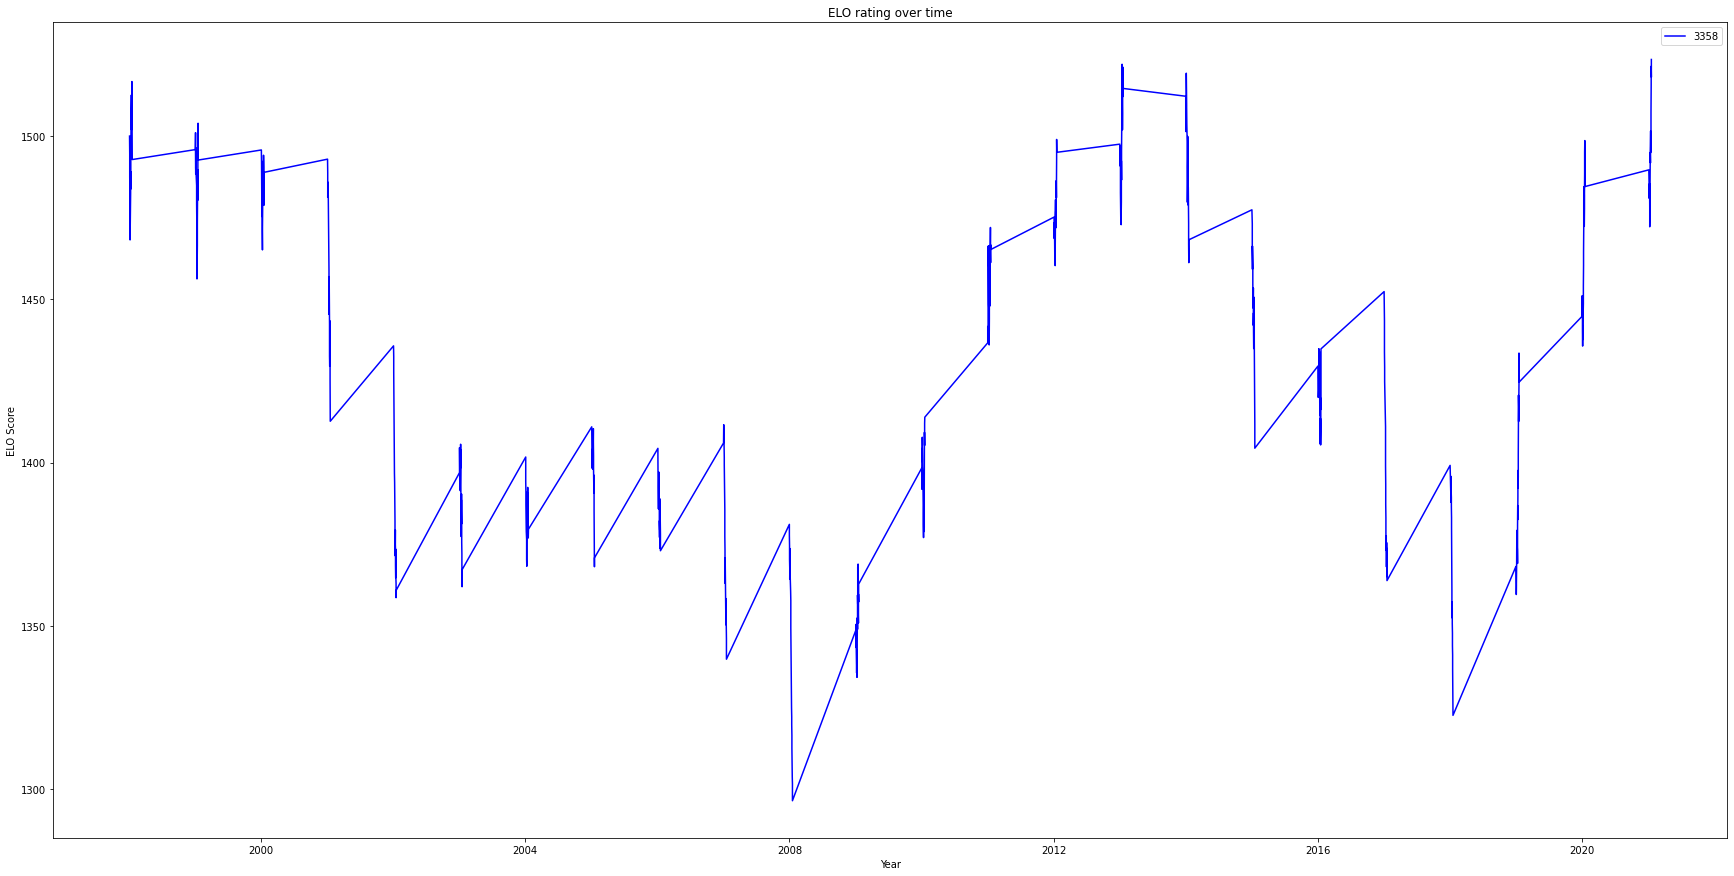

In [74]:
teams_to_plot = [3350, 3311, 3358]
plot_elo(kappa, teams_to_plot)

# Data merging

In [28]:
def merge_win_rate(df):
  df = df.merge(win_rate_frame, how='left', left_on=['Season', 'Team1'], 
                                      right_on=['Season', 'TeamID']).drop(['TeamID', 'Games', 'Wins'], axis=1)
  df = df.merge(win_rate_frame, how='left', left_on=['Season', 'Team2'], 
                                     right_on=['Season', 'TeamID']).drop(['TeamID', 'Games', 'Wins'], axis=1)                                      
  ren = {'win_rate_x': 'T1_WR', 
          'win_rate_y': 'T2_WR', 
          'Score_x': 'T1_Score', 
          'Score_y': 'T2_Score', 
          #'Wins_x': 'T1_Wins', 
          #'Wins_y': 'T2_Wins'
        }
  df = df.rename(columns = ren)
  return df

In [29]:
def merge_data(df, data_to_merge):
  if ('WTeamID' in df.columns) or ('LTeamID' in df.columns):
    df = shuffle_data(df)
  df['Team1'] = df['Team1'].astype(np.int)
  df['Team2'] = df['Team2'].astype(np.int)
  df['Season'] = df['Season'].astype(np.int)
  df = df.merge(data_to_merge, how='left', left_on=['Season', 'Team1'], 
                                      right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'ELO':'T1_ELO'})
  df = df.merge(data_to_merge, how='left', left_on=['Season', 'Team2'], 
                                      right_on=['Season', 'TeamID']).drop('TeamID', axis=1).rename(columns={'ELO':'T2_ELO'})
  
  df = merge_win_rate(df)
  df = add_seed(df)
  df['seed_diff'] = df.T1Seed - df.T2Seed
  df['elo_diff'] = df.T1_ELO - df.T2_ELO  
  df['WR_diff'] = df.T1_WR - df.T2_WR
  df['Score_diff'] = df.T1_Score - df.T2_Score
  return df                                    

In [68]:
td = merge_data(td, team_elo_at_each_season)

In [69]:
td

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,Team1,Team2,target,T1_ELO,T2_ELO,T1_Score,T1_WR,T2_Score,T2_WR,T1Seed,T2Seed,seed_diff,elo_diff,WR_diff,Score_diff
0,1998,137,3104,94,3422,46,H,0,3422,3104,0.0,1461.873535,1601.141171,2010,0.703704,2297,0.700000,15.0,2.0,13.0,-139.267636,0.003704,-287
1,1998,137,3112,75,3365,63,H,0,3365,3112,0.0,1492.513563,1653.889145,2144,0.785714,2116,0.777778,14.0,3.0,11.0,-161.375582,0.007937,28
2,1998,137,3163,93,3193,52,H,0,3163,3193,1.0,1788.241068,1516.007148,2696,0.937500,1950,0.714286,2.0,15.0,-13.0,272.233920,0.223214,746
3,1998,137,3198,59,3266,45,H,0,3198,3266,1.0,1433.155930,1675.557006,2337,0.965517,1907,0.769231,7.0,10.0,-3.0,-242.401076,0.196286,430
4,1998,137,3203,74,3208,72,A,0,3208,3203,0.0,1643.254987,1477.082002,1996,0.653846,1818,0.653846,7.0,10.0,-3.0,166.172985,0.000000,178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1381,2019,147,3124,85,3234,53,N,0,3124,3234,1.0,1788.970413,1663.463323,2575,0.968750,2555,0.812500,1.0,2.0,-1.0,125.507090,0.156250,20
1382,2019,147,3323,84,3390,68,H,0,3323,3390,1.0,1596.949056,1755.182195,2938,0.909091,2393,0.875000,1.0,2.0,-1.0,-158.233139,0.034091,545
1383,2019,151,3124,72,3332,67,N,0,3332,3124,0.0,1693.446180,1788.970413,2725,0.875000,2575,0.968750,2.0,1.0,1.0,-95.524233,-0.093750,150
1384,2019,151,3323,81,3163,76,N,0,3163,3323,0.0,1788.241068,1596.949056,2726,0.939394,2938,0.909091,2.0,1.0,1.0,191.292012,0.030303,-212


In [70]:
td.to_csv(path+'boosted_tourney.csv', index=False)

## Preapering teams to predict their win chance

In [121]:
ss.head()

,ID,Pred
0,2021_3104_3112,0.5
1,2021_3104_3116,0.5
2,2021_3104_3124,0.5
3,2021_3104_3125,0.5
4,2021_3104_3133,0.5


In [122]:
ss['Team1'] = ss['ID'].map(lambda s: s[5:9])
ss['Team2'] = ss['ID'].map(lambda s: s[10:])
ss['Season'] = ss['ID'].map(lambda s: s[:4])

In [123]:
ss.head()

,ID,Pred,Team1,Team2,Season
0,2021_3104_3112,0.5,3104,3112,2021
1,2021_3104_3116,0.5,3104,3116,2021
2,2021_3104_3124,0.5,3104,3124,2021
3,2021_3104_3125,0.5,3104,3125,2021
4,2021_3104_3133,0.5,3104,3133,2021


In [124]:
ss = merge_data(ss, team_elo_at_each_season)

In [125]:
ss.head()

,ID,Pred,Team1,Team2,Season,T1_ELO,T2_ELO,T1_Score,T1_WR,T2_Score,T2_WR,T1Seed,T2Seed,seed_diff,elo_diff,WR_diff,Score_diff
0,2021_3104_3112,0.5,3104,3112,2021,1601.141171,1653.889145,1870,0.64,1398,0.761905,7.0,3.0,4.0,-52.747974,-0.121905,472
1,2021_3104_3116,0.5,3104,3116,2021,1601.141171,1638.551777,1870,0.64,2243,0.703704,7.0,4.0,3.0,-37.410606,-0.063704,-373
2,2021_3104_3124,0.5,3104,3124,2021,1601.141171,1788.970413,1870,0.64,2203,0.925926,7.0,2.0,5.0,-187.829242,-0.285926,-333
3,2021_3104_3125,0.5,3104,3125,2021,1601.141171,1625.315235,1870,0.64,1761,0.800000,7.0,12.0,-5.0,-24.174064,-0.160000,109
4,2021_3104_3133,0.5,3104,3133,2021,1601.141171,1563.609381,1870,0.64,1884,0.592593,7.0,11.0,-4.0,37.531790,0.047407,-14


# XGBoost Model

## Correlation matrix

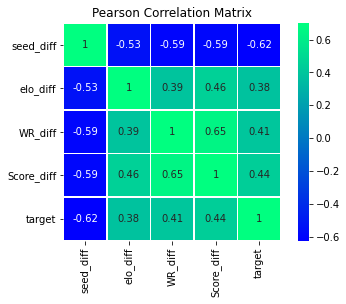

In [119]:
plt.title('Pearson Correlation Matrix')
sns.heatmap(td[['seed_diff', 'elo_diff', 'WR_diff', 'Score_diff', 'target']].corr(),linewidths=0.45,vmax=0.7,square=True,cmap="winter",
            linecolor='w',annot=True);

In [65]:
td = pd.read_csv(path+'boosted_tourney.csv')

## XGBoost Classifier

In [141]:
np.random.seed(42)
cols_x = ['elo_diff', 'WR_diff', 'seed_diff', 'Score_diff']
cols_y = 'target'
model = XGBClassifier(4,
                          0.005, 
                          2000, 
                          objective='binary:logistic', 
                          feature_selector = 'shuffle',
                          n_jobs=-1, 
                          reg_alpha=0.3, 
                          reg_lambda=0.035, 
                          gamma=0.8, 
                          min_child_weight=0.8,
                          tree_method='hist',
                          random_state=2021)
#td = td.loc[td['Season'] >= 2019]
X = td[cols_x]
y = td[cols_y]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=2021)
X_test = X_train[:50]
y_test = y_train[:50]
X_train = X_train[50:]
y_train = y_train[50:]
model.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)],
              eval_metric='logloss',
              early_stopping_rounds=100
              )

pred2 = model.predict_proba(X_test)
loss = log_loss(y_test, pred2)
print('Test loss: ', loss)

[0]	validation_0-logloss:0.691017
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.688909
[2]	validation_0-logloss:0.686823
[3]	validation_0-logloss:0.68475
[4]	validation_0-logloss:0.682707
[5]	validation_0-logloss:0.680676
[6]	validation_0-logloss:0.678674
[7]	validation_0-logloss:0.676684
[8]	validation_0-logloss:0.674723
[9]	validation_0-logloss:0.672772
[10]	validation_0-logloss:0.670851
[11]	validation_0-logloss:0.668939
[12]	validation_0-logloss:0.667056
[13]	validation_0-logloss:0.665182
[14]	validation_0-logloss:0.663336
[15]	validation_0-logloss:0.661532
[16]	validation_0-logloss:0.659722
[17]	validation_0-logloss:0.657961
[18]	validation_0-logloss:0.65621
[19]	validation_0-logloss:0.654461
[20]	validation_0-logloss:0.652743
[21]	validation_0-logloss:0.651028
[22]	validation_0-logloss:0.649342
[23]	validation_0-logloss:0.64766
[24]	validation_0-logloss:0.646038
[25]	validation_0-logloss:0.644412
[26]	validation_0-logloss:0.642821

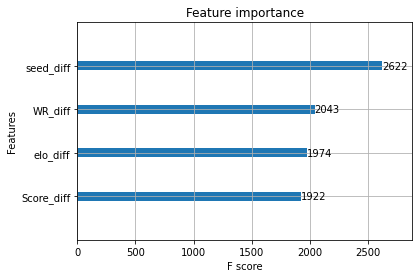

In [139]:
plot_importance(model)

In [114]:
'''
from sklearn.model_selection import RandomizedSearchCV
params = {'max_depth': [i for i in range(4, 31)],
          'learning_rate': [0.005, 0.001, 0.01, 0.015, 0.02], 
          'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
          'reg_lambda': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
          'gamma':[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1], 
          'min_child_weight':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
          'max_delta_step': [0, 0.1, 0.2, 0.005, 0.002, 0.001, 0.01, 0.02],
          'colsample_bytree': [1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
          'colsample_bylevel': [1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
          'colsample_bynode': [1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
}
estim = xgb.XGBRegressor(n_estimators=4000, tree_method='hist', objective='binary:logistic', feature_selector='shuffle', n_jobs=-1, random_state=2021)
callback_loss = make_scorer(log_loss) # this makes log_loss function callable to evaluate random search
'''

In [115]:
#random_search = RandomizedSearchCV(estim, params, n_iter=50, cv = 49, scoring = callback_loss, refit = True, return_train_score=True)

# Predicted probability

In [135]:
pred = model.predict_proba(ss[cols_x])
ss['Pred'] = pred
ss.to_csv(path+'submission.csv', columns=['ID','Pred'], index=None)
ss


,ID,Pred,Team1,Team2,Season,T1_ELO,T2_ELO,T1_Score,T1_WR,T2_Score,T2_WR,T1Seed,T2Seed,seed_diff,elo_diff,WR_diff,Score_diff
0,2021_3104_3112,0.718565,3104,3112,2021,1601.141171,1653.889145,1870,0.640000,1398,0.761905,7.0,3.0,4.0,-52.747974,-0.121905,472
1,2021_3104_3116,0.718084,3104,3116,2021,1601.141171,1638.551777,1870,0.640000,2243,0.703704,7.0,4.0,3.0,-37.410606,-0.063704,-373
2,2021_3104_3124,0.860342,3104,3124,2021,1601.141171,1788.970413,1870,0.640000,2203,0.925926,7.0,2.0,5.0,-187.829242,-0.285926,-333
3,2021_3104_3125,0.203237,3104,3125,2021,1601.141171,1625.315235,1870,0.640000,1761,0.800000,7.0,12.0,-5.0,-24.174064,-0.160000,109
4,2021_3104_3133,0.309644,3104,3133,2021,1601.141171,1563.609381,1870,0.640000,1884,0.592593,7.0,11.0,-4.0,37.531790,0.047407,-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,2021_3450_3460,0.400590,3450,3460,2021,1534.581139,1593.873890,1464,0.521739,1590,0.720000,9.0,13.0,-4.0,-59.292751,-0.198261,-126
2012,2021_3450_3461,0.296383,3450,3461,2021,1534.581139,1555.141716,1464,0.521739,1421,0.608696,9.0,14.0,-5.0,-20.560577,-0.086957,43
2013,2021_3452_3460,0.094811,3452,3460,2021,1654.843110,1593.873890,1963,0.777778,1590,0.720000,4.0,13.0,-9.0,60.969219,0.057778,373
2014,2021_3452_3461,0.036803,3452,3461,2021,1654.843110,1555.141716,1963,0.777778,1421,0.608696,4.0,14.0,-10.0,99.701393,0.169082,542
